In [1]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

d:\sy\test\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
from torchvision import datasets
import pandas as pd

IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 데이터셋 디렉토리 설정
train_dir = '../PCB_imgs/all/resize/train'
val_dir = '../PCB_imgs/all/resize/validation'
test_dir = '../PCB_imgs/all/resize/test'

# ImageFolder로 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 파일 경로 및 타겟 추출
train_file_paths = [img[0] for img in train_dataset.imgs]
train_targets = train_dataset.targets

val_file_paths = [img[0] for img in val_dataset.imgs]
val_targets = val_dataset.targets

test_file_paths = [img[0] for img in test_dataset.imgs]
test_targets = test_dataset.targets

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_file_paths, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': val_file_paths, 'targets': val_targets})
test_df = pd.DataFrame({'file_paths': test_file_paths, 'targets': test_targets})

# 확인을 위해 각 데이터셋의 크기 출력
print(f"Train 데이터 수: {len(train_df)}")
print(f"Validation 데이터 수: {len(validation_df)}")
print(f"Test 데이터 수: {len(test_df)}")

Train 데이터 수: 2008
Validation 데이터 수: 502
Test 데이터 수: 628


In [4]:
import torch
from torchvision import datasets, transforms

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 256, 256])


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name in 'vgg16':
            return 25088  # VGG16의 출력 차원
        elif model_name in ['resnet50', 'inception']:
            return 2048  # ResNet50, inception의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Sigmoid 제거
        # x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            outputs = outputs.view(-1) # torch.Size([batch_size])로 변환
            loss = criterion(outputs, labels)  # 손실 계산
            running_test_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # 0.5 기준으로 이진 분류
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # 검증 손실과 정확도
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    return test_loss, test_accuracy

##### resnet50 모델 구조만 이용

In [16]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16()
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50()
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3()
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2()
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.fc1 = nn.Linear(self._get_features_dim(model_name), 1)

    def _get_features_dim(self, model_name):
        if model_name in 'vgg16':
            return 25088  # VGG16의 출력 차원
        elif model_name in ['resnet50', 'inception']:
            return 2048  # ResNet50, inception의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

In [17]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(DEVICE)
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [19]:
EPOCHS = 20

# 조기 종료 변수를 초기화합니다.
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 모델 훈련
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장 코드를 추가할 수 있습니다.
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

Epoch [1/20], Train Loss: 0.2570, Train Accuracy: 0.8914, Val Loss: 0.3931, Val Accuracy: 0.8665
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.2268, Train Accuracy: 0.9054, Val Loss: 0.7432, Val Accuracy: 0.7490
Epoch [3/20], Train Loss: 0.2269, Train Accuracy: 0.9039, Val Loss: 0.3203, Val Accuracy: 0.8526
Validation loss improved, saving model...
Epoch [4/20], Train Loss: 0.1648, Train Accuracy: 0.9363, Val Loss: 0.3409, Val Accuracy: 0.8765
Epoch [5/20], Train Loss: 0.1572, Train Accuracy: 0.9343, Val Loss: 0.3263, Val Accuracy: 0.8725
Epoch [6/20], Train Loss: 0.1736, Train Accuracy: 0.9328, Val Loss: 0.2887, Val Accuracy: 0.9024
Validation loss improved, saving model...
Epoch [7/20], Train Loss: 0.1187, Train Accuracy: 0.9562, Val Loss: 0.4804, Val Accuracy: 0.8386
Epoch [8/20], Train Loss: 0.1238, Train Accuracy: 0.9567, Val Loss: 0.3641, Val Accuracy: 0.8924
Epoch [9/20], Train Loss: 0.0853, Train Accuracy: 0.9686, Val Loss: 0.4450, Val Accuracy: 0.8845
E

11 epoch -> 4m 27.2s  
1 epoch -> 24s

In [20]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5676, Test Accuracy: 0.8392


11epoch에서 early stopping 발생  
Train: 0.97 Val: 0.85, Test: 0.84 -> 훈련데이터에 대해 과적합. 

Imagenet 데이터에 대해 미리 학습된 파라미터 값을 사용해서 훈련진행해보기.

##### resnet50모델 구조 + ImageNet 데이터에 대해 미리 학습된 파라미터값 사용

In [30]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.fc1 = nn.Linear(self._get_features_dim(model_name), 1)

    def _get_features_dim(self, model_name):
        if model_name in 'vgg16':
            return 25088  # VGG16의 출력 차원
        elif model_name in ['resnet50', 'inception']:
            return 2048  # ResNet50, inception의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x) 
        return x

In [22]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(DEVICE)
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [23]:
EPOCHS = 20

# 조기 종료 변수를 초기화합니다.
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 모델 훈련
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장 코드를 추가할 수 있습니다.
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

Epoch [1/20], Train Loss: 0.3328, Train Accuracy: 0.8426, Val Loss: 0.2410, Val Accuracy: 0.9004
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.1336, Train Accuracy: 0.9517, Val Loss: 0.2629, Val Accuracy: 0.9064
Epoch [3/20], Train Loss: 0.0812, Train Accuracy: 0.9706, Val Loss: 0.2606, Val Accuracy: 0.9124
Epoch [4/20], Train Loss: 0.0726, Train Accuracy: 0.9731, Val Loss: 0.3573, Val Accuracy: 0.8805
Epoch [5/20], Train Loss: 0.0432, Train Accuracy: 0.9831, Val Loss: 0.2551, Val Accuracy: 0.9243
Epoch [6/20], Train Loss: 0.0246, Train Accuracy: 0.9930, Val Loss: 0.1567, Val Accuracy: 0.9522
Validation loss improved, saving model...
Epoch [7/20], Train Loss: 0.0250, Train Accuracy: 0.9905, Val Loss: 0.1648, Val Accuracy: 0.9622
Epoch [8/20], Train Loss: 0.0334, Train Accuracy: 0.9866, Val Loss: 0.1363, Val Accuracy: 0.9562
Validation loss improved, saving model...
Epoch [9/20], Train Loss: 0.0228, Train Accuracy: 0.9895, Val Loss: 0.2141, Val Accuracy: 0.9482
E

18 epoch -> 7m 14.2s
1 epoch -> 24s

In [24]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1797, Test Accuracy: 0.9602


훈련 데이터의 손실값은 계속 감소하는 추세인 반면, 검증 데이터의 손실값은 7epoch이후 감소와 증가를 반복함. -> 일반화가 잘 되지 않았음을 의미.  
약간의 과적합 양상을 보임.

##### Resnet50 모델 + ImageNet 파라미터 사용 + 데이터 증강

In [32]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(DEVICE)
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [34]:
EPOCHS = 20

# 조기 종료 변수를 초기화합니다.
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 모델 훈련
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/resnet_best_model.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

Epoch [1/20], Train Loss: 0.3786, Train Accuracy: 0.8172, Val Loss: 0.3119, Val Accuracy: 0.8566
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.2570, Train Accuracy: 0.8914, Val Loss: 0.3166, Val Accuracy: 0.8645
Epoch [3/20], Train Loss: 0.2064, Train Accuracy: 0.9074, Val Loss: 0.3180, Val Accuracy: 0.8685
Epoch [4/20], Train Loss: 0.1791, Train Accuracy: 0.9293, Val Loss: 0.2129, Val Accuracy: 0.9044
Validation loss improved, saving model...
Epoch [5/20], Train Loss: 0.1195, Train Accuracy: 0.9492, Val Loss: 0.2306, Val Accuracy: 0.9203
Epoch [6/20], Train Loss: 0.1024, Train Accuracy: 0.9612, Val Loss: 0.1479, Val Accuracy: 0.9462
Validation loss improved, saving model...
Epoch [7/20], Train Loss: 0.0746, Train Accuracy: 0.9726, Val Loss: 0.1610, Val Accuracy: 0.9402
Epoch [8/20], Train Loss: 0.0572, Train Accuracy: 0.9811, Val Loss: 0.1132, Val Accuracy: 0.9562
Validation loss improved, saving model...
Epoch [9/20], Train Loss: 0.0495, Train Accuracy: 0.9826

In [38]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='resnet50').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/resnet_best_model.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 옵티마이저에 체크포인트 적용 (옵션)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_3988\1288536159.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet_best_model.pth')


CustomModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [40]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0659, Test Accuracy: 0.9825


20 epoch -> 8m 15.5s  
1 epoch -> 25s

Train:0.99 (0.01) / Val: 0.98 (0.07) / Test: 0.98 (0.06) 으로 과적합없이 높은 정확도와 낮은 손실값의 모델이 훈련.

#### kfold 교차검증 5번
각 epoch 20번

In [28]:
IMAGE_SIZE = 256

class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess
        
        # 레이블 매핑 (예: 'OK': 0, 'NG': 1)
        self.label_mapping = {label: idx for idx, label in enumerate(set(targets))}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        # 이미지 로드
        image = cv2.imread(file_path)
        
        # BGR -> RGB 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 이미지 크기 조정
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # 데이터 증강 적용
        if self.aug is not None:
            image = self.aug(image=image)['image']

        # 추가적인 전처리
        if self.preprocess is not None:
            image = self.preprocess(image)

        # 이미지 차원 변환 (H, W, C) -> (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        
        # 텐서로 변환
        image = torch.tensor(image, dtype=torch.float32)

        # 타겟을 정수로 변환하고 텐서로 변환
        target = self.label_mapping[target]  # 문자열을 정수로 변환
        target = torch.tensor(target, dtype=torch.float32)  # 또는 적절한 dtype으로 변환

        return image, target


In [29]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as A

# 데이터셋 디렉토리 설정
data_dir = '../PCB_imgs/all/resize/all'  # 모든 이미지를 포함하는 디렉토리

# 이미지와 레이블 로드
def load_data(data_dir):
    file_paths = []
    targets = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(label_dir):
            file_paths.append(os.path.join(label_dir, img_file))
            targets.append(label)
    return pd.DataFrame({'file_paths': file_paths, 'targets': targets})

# 전체 데이터셋 로드
full_dataset = load_data(data_dir)

# 전체 데이터셋에서 Train (80%)과 Validation (20%) 나누기
train_df, val_df = train_test_split(full_dataset, test_size=0.2, random_state=124)

# Train, Validation 데이터 개수 확인
print(f'Train 데이터 수: {len(train_df)}')     
print(f'Validation 데이터 수: {len(val_df)}') 

# k-Fold Cross Validation 설정
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=124)

# 성능 저장을 위한 리스트 초기화
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

# 5번 k-Fold Cross Validation 진행
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 각 fold에 대해 데이터셋 설정
    train_subset = train_df.iloc[train_idx]
    validation_subset = train_df.iloc[val_idx]

    aug = A.Compose([
        A.HorizontalFlip(p=0.5),                # 좌우 반전
        A.VerticalFlip(p=0.5),                  # 상하 반전
        A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
        A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
    ])

    # 데이터셋 인스턴스 생성 (CustomDataset은 사용자의 데이터셋 클래스)
    train_dataset = CustomDataset(train_subset['file_paths'].values, train_subset['targets'].values, aug=aug)
    validation_dataset = CustomDataset(validation_subset['file_paths'].values, validation_subset['targets'].values)

    # DataLoader 설정
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 모델 초기화
    model = CustomModel(model_name='resnet50').to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0

    # 각 fold에 대해 학습 진행
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for images, targets in train_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # 손실 계산
            loss = criterion(outputs.view(-1), targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 정확도 계산
            predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
        
        train_accuracy = correct_predictions / total_predictions
        fold_train_losses.append(running_loss / len(train_loader))
        fold_train_accuracies.append(train_accuracy)

        # 검증
        model.eval()
        val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)
        fold_val_losses.append(val_loss)
        fold_val_accuracies.append(val_accuracy)
        
        # 조기 종료 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # 개선 시 카운터 리셋
        else:
            patience_counter += 1  # 개선 없을 시 카운터 증가
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    print(f'Fold {fold + 1} completed. Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# 최종 성능 요약
print("Training completed across all folds.")


Train 데이터 수: 2510
Validation 데이터 수: 628
Fold 1/5
Early stopping triggered.
Fold 1 completed. Train Loss: 0.0163, Train Accuracy: 0.9950, Val Loss: 0.1077, Val Accuracy: 0.9841
Fold 2/5
Fold 2 completed. Train Loss: 0.0203, Train Accuracy: 0.9950, Val Loss: 0.0678, Val Accuracy: 0.9880
Fold 3/5
Early stopping triggered.
Fold 3 completed. Train Loss: 0.0357, Train Accuracy: 0.9915, Val Loss: 0.0817, Val Accuracy: 0.9721
Fold 4/5
Fold 4 completed. Train Loss: 0.0313, Train Accuracy: 0.9905, Val Loss: 0.1220, Val Accuracy: 0.9761
Fold 5/5
Fold 5 completed. Train Loss: 0.0234, Train Accuracy: 0.9930, Val Loss: 0.1074, Val Accuracy: 0.9741
Training completed across all folds.


In [31]:
# k-Fold 결과 평균 계산
print(f'\n{k_folds}-Fold Cross Validation Results:')
print(f'Average Train Loss: {np.mean(fold_train_losses):.4f}')
print(f'Average Train Accuracy: {np.mean(fold_train_accuracies):.4f}')
print(f'Average Val Loss: {np.mean(fold_val_losses):.4f}')
print(f'Average Val Accuracy: {np.mean(fold_val_accuracies):.4f}')


5-Fold Cross Validation Results:
Average Train Loss: 0.0924
Average Train Accuracy: 0.9637
Average Val Loss: 0.1358
Average Val Accuracy: 0.9545


#### fine tuning  
1차 fine tuning(데이터 증강 + base model 파라미터 freeze)

In [32]:
from torchvision import datasets
import pandas as pd

IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 데이터셋 디렉토리 설정
train_dir = '../PCB_imgs/all/resize/train'
val_dir = '../PCB_imgs/all/resize/validation'
test_dir = '../PCB_imgs/all/resize/test'

# ImageFolder로 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 파일 경로 및 타겟 추출
train_file_paths = [img[0] for img in train_dataset.imgs]
train_targets = train_dataset.targets

val_file_paths = [img[0] for img in val_dataset.imgs]
val_targets = val_dataset.targets

test_file_paths = [img[0] for img in test_dataset.imgs]
test_targets = test_dataset.targets

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_file_paths, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': val_file_paths, 'targets': val_targets})
test_df = pd.DataFrame({'file_paths': test_file_paths, 'targets': test_targets})

# 확인을 위해 각 데이터셋의 크기 출력
print(f"Train 데이터 수: {len(train_df)}")
print(f"Validation 데이터 수: {len(validation_df)}")
print(f"Test 데이터 수: {len(test_df)}")

Train 데이터 수: 2008
Validation 데이터 수: 502
Test 데이터 수: 628


In [33]:
import torch
from torchvision import datasets, transforms

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/all/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 256, 256])


In [34]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [35]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.fc1 = nn.Linear(self._get_features_dim(model_name), 1)

    def _get_features_dim(self, model_name):
        if model_name in 'vgg16':
            return 25088  # VGG16의 출력 차원
        elif model_name in ['resnet50', 'inception']:
            return 2048  # ResNet50, inception의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x) 
        return x

In [52]:
import torch.optim as optim

# 모델 생성
model = CustomModel(model_name='resnet50').to(DEVICE)

# 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 새로 추가된 분류기 레이어만 학습
optimizer = optim.Adam(model.fc1.parameters(), lr=0.0001) 

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.0.weight | Requires Grad: False
Layer: base_model.1.weight | Requires Grad: False
Layer: base_model.1.bias | Requires Grad: False
Layer: base_model.4.0.conv1.weight | Requires Grad: False
Layer: base_model.4.0.bn1.weight | Requires Grad: False
Layer: base_model.4.0.bn1.bias | Requires Grad: False
Layer: base_model.4.0.conv2.weight | Requires Grad: False
Layer: base_model.4.0.bn2.weight | Requires Grad: False
Layer: base_model.4.0.bn2.bias | Requires Grad: False
Layer: base_model.4.0.conv3.weight | Requires Grad: False
Layer: base_model.4.0.bn3.weight | Requires Grad: False
Layer: base_model.4.0.bn3.bias | Requires Grad: False
Layer: base_model.4.0.downsample.0.weight | Requires Grad: False
Layer: base_model.4.0.downsample.1.weight | Requires Grad: False
Layer: base_model.4.0.downsample.1.bias | Requires Grad: False
Layer: base_model.4.1.conv1.weight | Requires Grad: False
Layer: base_model.4.1.bn1.weight | Requires Grad: False
Layer: base_model.4.1.bn1.bias | Requires

In [38]:
EPOCHS = 20

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    # scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/resnet_ft_best_model_01.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/20], Train Loss: 0.6215, Train Accuracy: 0.6683, Val Loss: 0.5801, Val Accuracy: 0.7669
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.5497, Train Accuracy: 0.7664, Val Loss: 0.5290, Val Accuracy: 0.7789
Validation loss improved, saving model...
Epoch [3/20], Train Loss: 0.5120, Train Accuracy: 0.7799, Val Loss: 0.4990, Val Accuracy: 0.7789
Validation loss improved, saving model...
Epoch [4/20], Train Loss: 0.4864, Train Accuracy: 0.7849, Val Loss: 0.4780, Val Accuracy: 0.7769
Validation loss improved, saving model...
Epoch [5/20], Train Loss: 0.4723, Train Accuracy: 0.7849, Val Loss: 0.4641, Val Accuracy: 0.7789
Validation loss improved, saving model...
Epoch [6/20], Train Loss: 0.4616, Train Accuracy: 0.7893, Val Loss: 0.4592, Val Accuracy: 0.7809
Validation loss improved, saving model...
Epoch [7/20], Train Loss: 0.4480, Train Accuracy: 0.7874, Val Loss: 0.4462, Val Accuracy: 0.7729
Validation loss improved, s

20 epoch -> 3m 58.5s  
1 epoch -> 11s

In [39]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3903, Test Accuracy: 0.8010


2차 fine tuning(데이터 증강 + 마지막 블록만 unfreeze)

In [40]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [61]:
import torchvision.models as models

# ResNet50 사전 학습된 모델 로드
model = models.resnet50(weights='IMAGENET1K_V1')

# 모델의 레이어 이름과 타입 확인
for name, layer in model.named_children():
    print(f"Layer Name: {name}, Layer Type: {layer}")

Layer Name: conv1, Layer Type: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Layer Name: bn1, Layer Type: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer Name: relu, Layer Type: ReLU(inplace=True)
Layer Name: maxpool, Layer Type: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Layer Name: layer1, Layer Type: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample)

In [62]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [63]:
# 모델 정의
model = CustomModel(model_name='resnet50').to(DEVICE)

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 마지막 bottleneck 블록 하나 동결 해제
for name, param in model.base_model.named_parameters():
    if '7.2' in name:  # layer4의 마지막 bottleneck 블록
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용
# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.base_model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: 0.weight | Requires Grad: False
Layer: 1.weight | Requires Grad: False
Layer: 1.bias | Requires Grad: False
Layer: 4.0.conv1.weight | Requires Grad: False
Layer: 4.0.bn1.weight | Requires Grad: False
Layer: 4.0.bn1.bias | Requires Grad: False
Layer: 4.0.conv2.weight | Requires Grad: False
Layer: 4.0.bn2.weight | Requires Grad: False
Layer: 4.0.bn2.bias | Requires Grad: False
Layer: 4.0.conv3.weight | Requires Grad: False
Layer: 4.0.bn3.weight | Requires Grad: False
Layer: 4.0.bn3.bias | Requires Grad: False
Layer: 4.0.downsample.0.weight | Requires Grad: False
Layer: 4.0.downsample.1.weight | Requires Grad: False
Layer: 4.0.downsample.1.bias | Requires Grad: False
Layer: 4.1.conv1.weight | Requires Grad: False
Layer: 4.1.bn1.weight | Requires Grad: False
Layer: 4.1.bn1.bias | Requires Grad: False
Layer: 4.1.conv2.weight | Requires Grad: False
Layer: 4.1.bn2.weight | Requires Grad: False
Layer: 4.1.bn2.bias | Requires Grad: False
Layer: 4.1.conv3.weight | Requires Grad: False
Lay

2-1. 20 epoch + early stopping 

In [64]:
EPOCHS = 20

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/ft_best_model_02.1.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/20], Train Loss: 0.5978, Train Accuracy: 0.6982, Val Loss: 0.5154, Val Accuracy: 0.7669
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.4734, Train Accuracy: 0.7649, Val Loss: 0.4317, Val Accuracy: 0.7908
Validation loss improved, saving model...
Epoch [3/20], Train Loss: 0.4101, Train Accuracy: 0.7988, Val Loss: 0.3965, Val Accuracy: 0.8127
Validation loss improved, saving model...
Epoch [4/20], Train Loss: 0.3757, Train Accuracy: 0.8177, Val Loss: 0.3705, Val Accuracy: 0.8207
Validation loss improved, saving model...
Epoch [5/20], Train Loss: 0.3532, Train Accuracy: 0.8317, Val Loss: 0.3497, Val Accuracy: 0.8347
Validation loss improved, saving model...
Epoch [6/20], Train Loss: 0.3306, Train Accuracy: 0.8352, Val Loss: 0.3329, Val Accuracy: 0.8386
Validation loss improved, saving model...
Epoch [7/20], Train Loss: 0.3211, Train Accuracy: 0.8501, Val Loss: 0.3174, Val Accuracy: 0.8506
Validation loss improved, s

20 epoch -> 4m 8.5s  
1 epoch -> 12s

In [65]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='resnet50').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/resnet_ft_best_model_02.1.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 마지막 bottleneck 블록 하나 동결 해제
for name, param in model.base_model.named_parameters():
    if '7.2' in name:  # layer4의 마지막 bottleneck 블록
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4788\1638579495.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet_ft_best_model_02.1.pth')


CustomModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [66]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2131, Test Accuracy: 0.9156


50 epoch + early stopping + 학습률 스케줄러

In [45]:
# 모델 정의
model = CustomModel(model_name='resnet50').to(DEVICE)

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 마지막 bottleneck 블록 하나 동결 해제
for name, param in model.base_model.named_parameters():
    if '7.2' in name:  # layer4의 마지막 bottleneck 블록
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용
# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.base_model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: 0.weight | Requires Grad: False
Layer: 1.weight | Requires Grad: False
Layer: 1.bias | Requires Grad: False
Layer: 4.0.conv1.weight | Requires Grad: False
Layer: 4.0.bn1.weight | Requires Grad: False
Layer: 4.0.bn1.bias | Requires Grad: False
Layer: 4.0.conv2.weight | Requires Grad: False
Layer: 4.0.bn2.weight | Requires Grad: False
Layer: 4.0.bn2.bias | Requires Grad: False
Layer: 4.0.conv3.weight | Requires Grad: False
Layer: 4.0.bn3.weight | Requires Grad: False
Layer: 4.0.bn3.bias | Requires Grad: False
Layer: 4.0.downsample.0.weight | Requires Grad: False
Layer: 4.0.downsample.1.weight | Requires Grad: False
Layer: 4.0.downsample.1.bias | Requires Grad: False
Layer: 4.1.conv1.weight | Requires Grad: False
Layer: 4.1.bn1.weight | Requires Grad: False
Layer: 4.1.bn1.bias | Requires Grad: False
Layer: 4.1.conv2.weight | Requires Grad: False
Layer: 4.1.bn2.weight | Requires Grad: False
Layer: 4.1.bn2.bias | Requires Grad: False
Layer: 4.1.conv3.weight | Requires Grad: False
Lay

In [46]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")  
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/resnet_ft_best_model_02.2.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.5955, Train Accuracy: 0.7102, Val Loss: 0.5053, Val Accuracy: 0.7610
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4635, Train Accuracy: 0.7864, Val Loss: 0.4335, Val Accuracy: 0.7829
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.4145, Train Accuracy: 0.7943, Val Loss: 0.3943, Val Accuracy: 0.8048
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.3778, Train Accuracy: 0.8142, Val Loss: 0.3728, Val Accuracy: 0.8167
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.3600, Train Accuracy: 0.8232, Val Loss: 0.3510, Val Accuracy: 0.8327
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.3317, Train Accuracy: 0.8466, Val Loss: 0.3412, Val Accuracy: 0.8466
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.3161, Train Accuracy: 0.8486, Val Loss: 0.3274, Val Accuracy: 0.8466
Validation loss improved, s

In [58]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='resnet50').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/resnet_ft_best_model_02.2.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 마지막 bottleneck 블록 하나 동결 해제
for name, param in model.base_model.named_parameters():
    if '7.2' in name:  # layer4의 마지막 bottleneck 블록
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4788\3408673509.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet_ft_best_model_02.2.pth')


CustomModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [60]:
# 테스트 데이터셋에 대한 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2017, Test Accuracy: 0.9252


50 epoch -> 10m 20.3s  
1 epoch -> 12s

3차 fine tuning (데이터 증강 + BN 층만 freeze)

In [48]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
# 모델 정의
model = CustomModel(model_name='resnet50').to(DEVICE)

# 1. 사전 학습된 레이어 동결 (처음에 모든 레이어를 동결)
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. BatchNorm2d 층만 동결, 나머지는 동결 해제
for name, param in model.base_model.named_parameters():
    if "bn" in name.lower(): 
        param.requires_grad = False
    else:
        param.requires_grad = True  

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# 학습할 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.base_model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: 0.weight | Requires Grad: True
Layer: 1.weight | Requires Grad: True
Layer: 1.bias | Requires Grad: True
Layer: 4.0.conv1.weight | Requires Grad: True
Layer: 4.0.bn1.weight | Requires Grad: False
Layer: 4.0.bn1.bias | Requires Grad: False
Layer: 4.0.conv2.weight | Requires Grad: True
Layer: 4.0.bn2.weight | Requires Grad: False
Layer: 4.0.bn2.bias | Requires Grad: False
Layer: 4.0.conv3.weight | Requires Grad: True
Layer: 4.0.bn3.weight | Requires Grad: False
Layer: 4.0.bn3.bias | Requires Grad: False
Layer: 4.0.downsample.0.weight | Requires Grad: True
Layer: 4.0.downsample.1.weight | Requires Grad: True
Layer: 4.0.downsample.1.bias | Requires Grad: True
Layer: 4.1.conv1.weight | Requires Grad: True
Layer: 4.1.bn1.weight | Requires Grad: False
Layer: 4.1.bn1.bias | Requires Grad: False
Layer: 4.1.conv2.weight | Requires Grad: True
Layer: 4.1.bn2.weight | Requires Grad: False
Layer: 4.1.bn2.bias | Requires Grad: False
Layer: 4.1.conv3.weight | Requires Grad: True
Layer: 4.1.bn3.

In [50]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/resnet_ft_best_model_03.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.5032, Train Accuracy: 0.7689, Val Loss: 0.3984, Val Accuracy: 0.7928
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.3613, Train Accuracy: 0.8257, Val Loss: 0.3270, Val Accuracy: 0.8526
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.2994, Train Accuracy: 0.8665, Val Loss: 0.2814, Val Accuracy: 0.8825
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.2352, Train Accuracy: 0.9074, Val Loss: 0.2448, Val Accuracy: 0.8944
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.2013, Train Accuracy: 0.9243, Val Loss: 0.2291, Val Accuracy: 0.8984
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.1657, Train Accuracy: 0.9402, Val Loss: 0.2215, Val Accuracy: 0.9064
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.1474, Train Accuracy: 0.9412, Val Loss: 0.1917, Val Accuracy: 0.9203
Validation loss improved, s

38 epoch -> 15m 37.3s  
1 epoch -> 30s

In [69]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='resnet50').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/resnet_ft_best_model_03.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 1. 사전 학습된 레이어 동결 (처음에 모든 레이어를 동결)
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. BatchNorm2d 층만 동결, 나머지는 동결 해제
for name, param in model.base_model.named_parameters():
    if "bn" in name.lower(): 
        param.requires_grad = False
    else:
        param.requires_grad = True  

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4788\2923962707.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet_ft_best_model_03.pth')


CustomModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [70]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1441, Test Accuracy: 0.9522


38 epoch -> 15m 37.3s  
1 epoch -> 25s

#### 정밀도, 재현율, f1 score로 평가

클래스: NG -> 0, OK -> 1 

True Positive(TP): 모델이 OK를 OK로 올바르게 분류한 경우  
False Positive(FP): 모델이 OK를 NG로 잘못 분류한 경우(error 1)  
True Negative(TN): 모델이 NG를 NG로 올바르게 분류한 경우  
False Negative(FN): 모델이 NG를 OK로 잘못 분류한 경우(error 2)  

정밀도(Precision): 모델이 OK로 예측했을 때, 실제로 OK인 비율  
재현율(Recall): 실제 OK인 이미지 중에 모델이 OK를 정확히 예측한 이미지의 비율. 즉, 모델이 NG를 얼마나 놓치지 않고 예측했는지를 의미.    
- error1이 error2보다 훨씬 나쁘다. 따라서 임계치를 높여 정밀도를 높이는 것이 적합하다.  

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

    # 오차 행렬 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    # 일반 오차 행렬
    disp = ConfusionMatrixDisplay(confusion, display_labels=['NG', 'OK'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title('Confusion Matrix')

    # 정규화된 오차 행렬
    normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]  # 정규화
    disp_normalized = ConfusionMatrixDisplay(normalized_confusion, display_labels=['NG', 'OK'])
    disp_normalized.plot(ax=axes[1], cmap=plt.cm.Blues)
    axes[1].set_title('Normalized Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
import numpy as np
import torch

# 정밀도-재현율 곡선 그리기 함수
def precision_recall_curve_plot(y_test, prediction_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, prediction_proba_class1)
    
    # 그래프 크기 설정
    plt.figure(figsize=(8, 6))
    
    # 정밀도와 재현율 플롯
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='Precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recall')
    
    # X축(threshold)의 Scale을 0 ~ 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [73]:
from sklearn.metrics import precision_recall_curve
import torch
import numpy as np

# 모델이 예측한 확률 값을 얻는 함수
def get_predictions_proba(model, test_loader):
    model.eval()
    all_predictions_proba = []
    all_targets = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, targets in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            
            # 예측 확률 계산 (sigmoid로 확률 변환)
            predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
            all_predictions_proba.extend(predicted_proba)
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions_proba), np.array(all_targets)

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation_no_pic(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

In [75]:
from sklearn.preprocessing import Binarizer

def get_evaluation_by_thresholds(y_test, prediction_proba_class1, thresholds):
    for threshold in thresholds:
        # Binarizer로 예측값을 이진화
        binarizer = Binarizer(threshold=threshold).fit(prediction_proba_class1) 
        custom_prediction = binarizer.transform(prediction_proba_class1).flatten()  # 차원 축소
        
        print('임곗값:', threshold)
        get_evaluation_no_pic(y_test, custom_prediction)  # 평가 함수 호출

In [76]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

# 평가 함수
def get_evaluation_by_custom_proba(y_test, prediction, visualize=False):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 80)
    
    if visualize:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[350  18]
 [ 12 248]]
정확도: 0.9522, 정밀도: 0.9323, 재현율: 0.9538, F1:0.9430, AUC:0.9525
###########################################################################


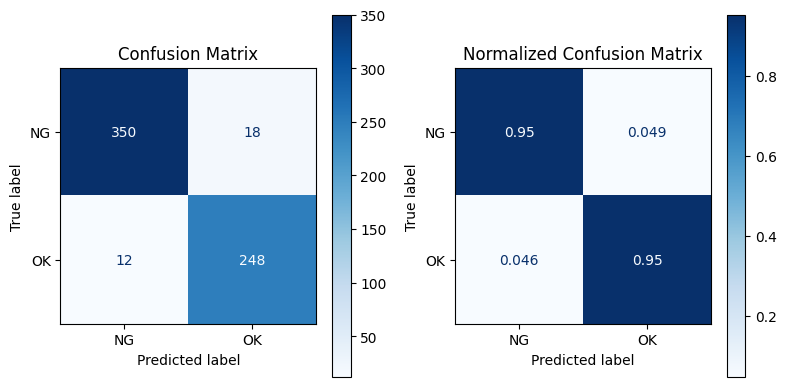

In [79]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

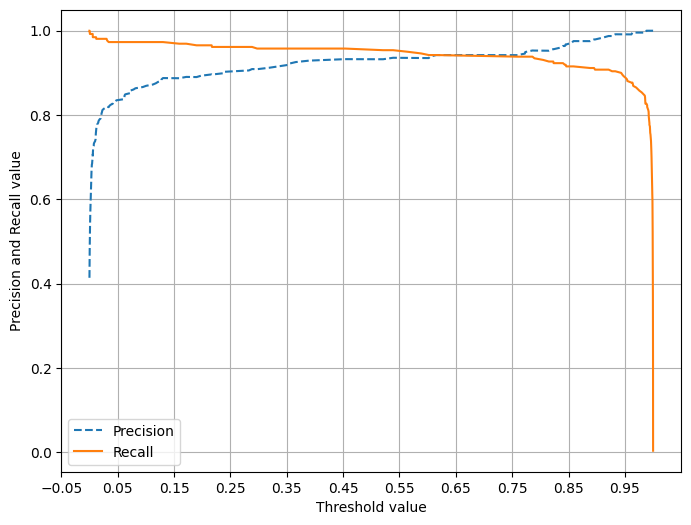

In [80]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [82]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[2.49747814e-06 4.81505504e-06 5.35431309e-06 1.10279279e-05
 1.52180255e-05 1.75564019e-05 2.14383635e-05 2.52662758e-05
 2.64679165e-05 2.79056003e-05 2.82072961e-05 2.90398493e-05
 3.21938387e-05 3.63543841e-05 3.88173758e-05 4.21091281e-05
 5.00474198e-05 5.33173115e-05 5.47266209e-05 6.34441531e-05
 6.45882028e-05 6.57029814e-05 7.31700129e-05 7.49881801e-05
 7.79706825e-05 8.14606610e-05 8.72539458e-05 8.73972604e-05
 9.13541589e-05 9.39314850e-05 9.65640211e-05 9.79351826e-05
 1.02774757e-04 1.04793791e-04 1.08117478e-04 1.16402844e-04
 1.21638230e-04 1.25331426e-04 1.26063751e-04 1.30328131e-04
 1.33143592e-04 1.37926341e-04 1.40337783e-04 1.40538134e-04
 1.51303568e-04 1.53343353e-04 1.57161339e-04 1.57369621e-04
 1.58614130e-04 1.62304044e-04 1.64232581e-04 1.64612618e-04
 1.64656565e-04 1.64773417e-04 1.68136539e-04 1.68763421e-04
 1.82341915e-04 1.84039716e-04 1.90456180e-04 1.91525876e-04
 1.98507973e-04 2.02300653e-04 2.06532699e-04 2.09149148e-04
 2.15206164e-04 2.287940

In [83]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 2.4974781e-06
오차 행렬
[[  1 367]
 [  0 260]]
정확도: 0.4156, 정밀도: 0.4147, 재현율: 1.0000, F1:0.5862, AUC:0.5014
###########################################################################
임곗값: 4.815055e-06
오차 행렬
[[  2 366]
 [  0 260]]
정확도: 0.4172, 정밀도: 0.4153, 재현율: 1.0000, F1:0.5869, AUC:0.5027
###########################################################################
임곗값: 5.354313e-06
오차 행렬
[[  3 365]
 [  0 260]]
정확도: 0.4188, 정밀도: 0.4160, 재현율: 1.0000, F1:0.5876, AUC:0.5041
###########################################################################
임곗값: 1.1027928e-05
오차 행렬
[[  4 364]
 [  0 260]]
정확도: 0.4204, 정밀도: 0.4167, 재현율: 1.0000, F1:0.5882, AUC:0.5054
###########################################################################
임곗값: 1.52180255e-05
오차 행렬
[[  5 363]
 [  0 260]]
정확도: 0.4220, 정밀도: 0.4173, 재현율: 1.0000, F1:0.5889, AUC:0.5068
###########################################################################
임곗값: 1.7556402e-05
오차 행렬
[[  6 362]
 [  0 260]]
정확도: 0.4236, 정밀도: 0.4180, 재현

d:\sy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차 행렬
[[362   6]
 [ 22 238]]
정확도: 0.9554, 정밀도: 0.9754, 재현율: 0.9154, F1: 0.9444, ROC-AUC: 0.9495
################################################################################


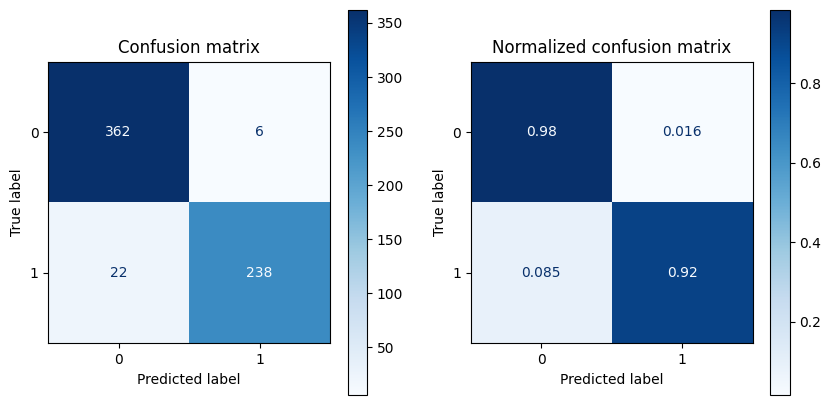

In [84]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.85577214
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)

In [109]:
import torch

# 모델과 임계값을 저장
save_data = {
    'model_state_dict': model.state_dict(),
    'threshold': threshold
}

# 모델 저장 경로 설정
model_save_path = "../model/resnet_with_threshold.pth"
torch.save(save_data, model_save_path)

print(f"모델과 임계값이 {model_save_path}에 저장되었습니다.")

모델과 임계값이 resnet_with_threshold.pth에 저장되었습니다.


In [110]:
# 모델과 임계값을 로드
loaded_data = torch.load(model_save_path)

# 모델의 가중치 불러오기
model.load_state_dict(loaded_data['model_state_dict'])
model.eval()  # 모델을 평가 모드로 전환

# 임계값 불러오기
loaded_threshold = loaded_data['threshold']

print("모델과 임계값이 로드되었습니다.")
print(f"로딩된 임계값: {loaded_threshold}")

모델과 임계값이 로드되었습니다.
로딩된 임계값: 0.85577214


C:\Users\enssel\AppData\Local\Temp\ipykernel_4788\679522368.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(model_save_path)


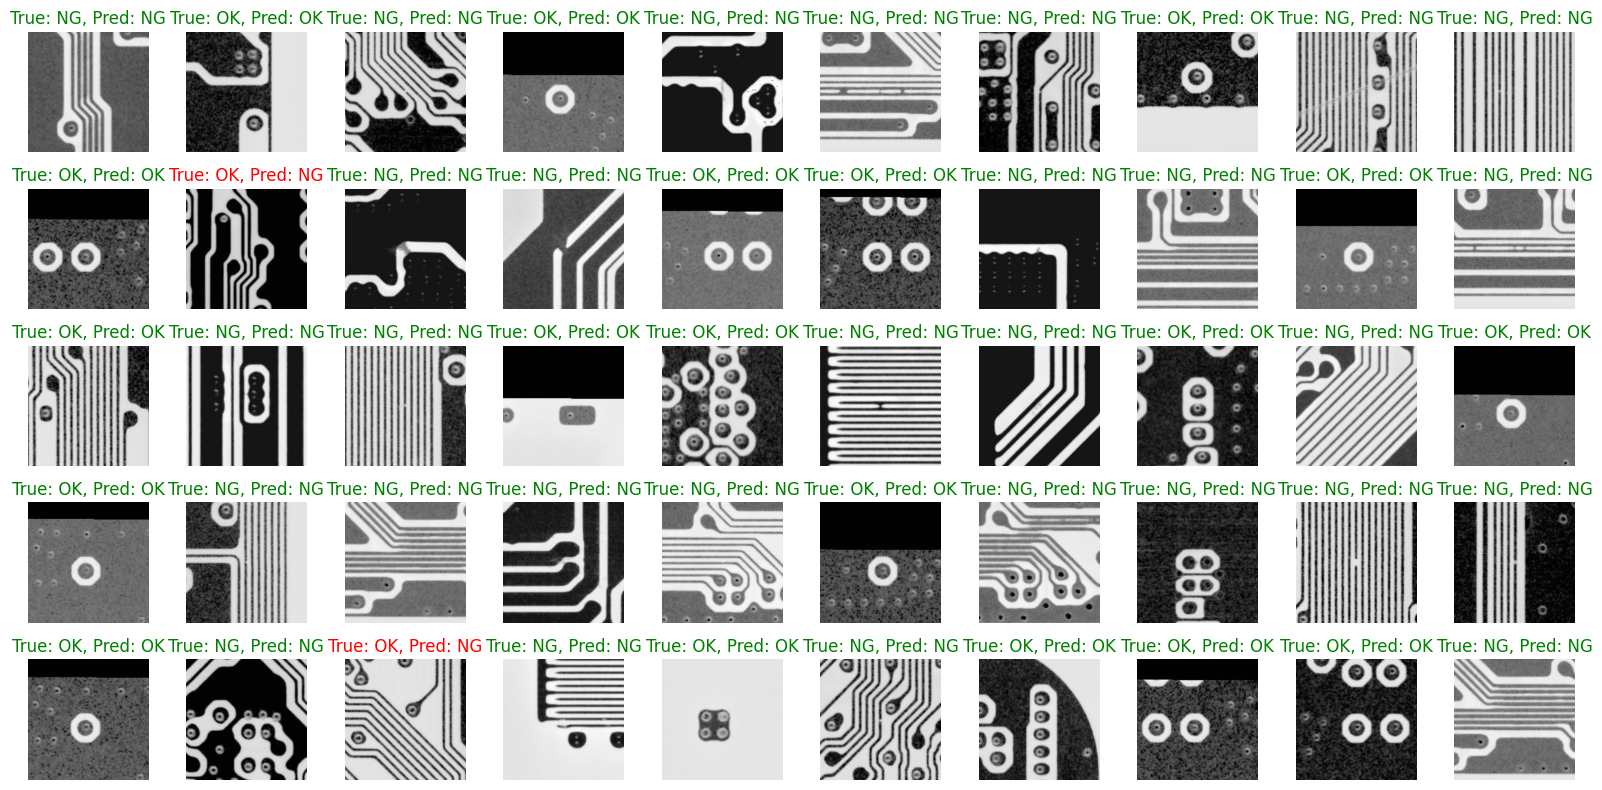

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# 테스트 데이터셋에서 무작위로 샘플을 선택하는 함수
def get_random_samples(dataset, num_samples=50):
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    return samples, indices

# 이미지 시각화 및 예측 결과 표시
def visualize_predictions(model, dataset, threshold=loaded_threshold, num_samples=50):
    # 모델을 평가 모드로 전환
    model.eval()
    
    # 무작위로 num_samples 개의 샘플 가져오기
    samples, indices = get_random_samples(dataset, num_samples=num_samples)
    
    fig, axs = plt.subplots(5, num_samples//5, figsize=(16, 8))  # 5행
    axs = axs.ravel()
    
    with torch.no_grad():
        for i, (image, label) in enumerate(samples):
            # 이미지와 레이블 준비
            image_input = image.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 및 장치로 이동
            label = label.item()
            
            # 예측 수행
            output = model(image_input)
            pred_proba = torch.sigmoid(output).item()  # 예측 확률
            pred_label = 1 if pred_proba > threshold else 0  # 임계값을 적용하여 이진 분류
            
            # 이미지를 numpy로 변환하여 시각화
            image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            image_np = (image_np * 255).astype(np.uint8)  # [0, 1] 범위에서 [0, 255] 범위로 변환
            
            # 정답/오답에 따른 레이블 색상 결정
            color = 'green' if pred_label == label else 'red'  # 정답일 때 녹색, 오답일 때 빨간색

            label_name = 'NG' if label == 0 else 'OK'
            pred_label_name = 'NG' if pred_label == 0 else 'OK'

            # 이미지 및 레이블 출력
            axs[i].imshow(image_np)
            axs[i].set_title(f"True: {label_name}, Pred: {pred_label_name}", color=color)
            axs[i].axis('off')  # 축 제거
    
    plt.tight_layout()
    plt.show()

# 모델을 사용하여 테스트 데이터에서 무작위 50개 샘플 예측 및 시각화
visualize_predictions(model, test_dataset, threshold=loaded_threshold)  # 저장된 임계값을 사용

finetuning 적용한 모델의 임계값을 올려 정밀도가 향상되게끔 조정.  
해당 모델로 실제 예측을 진행한 결과: 48 / 50 (정확도: 대략 0.96)  
오답 비율: OK인데 NG로 예측한 것이 많다. -> 임계값 조정 후, 해당 데이터에 조금 더 최적화된 모델이 된 것을 확인.

#### ㅍfine tuning 적용하지 않고 훈련했던 모델 로드 하여 임계값 조정해보기  
Resnet모델 구조 + ImageNet 파라미터 + 데이터 증강 + 20 epoch + early stopping 적용하여 훈련한 모델

In [132]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='resnet50').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/resnet_best_model.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4788\2087163528.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet_best_model.pth')


CustomModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

오차 행렬
[[366   2]
 [  9 251]]
정확도: 0.9825, 정밀도: 0.9921, 재현율: 0.9654, F1:0.9786, AUC:0.9800
###########################################################################


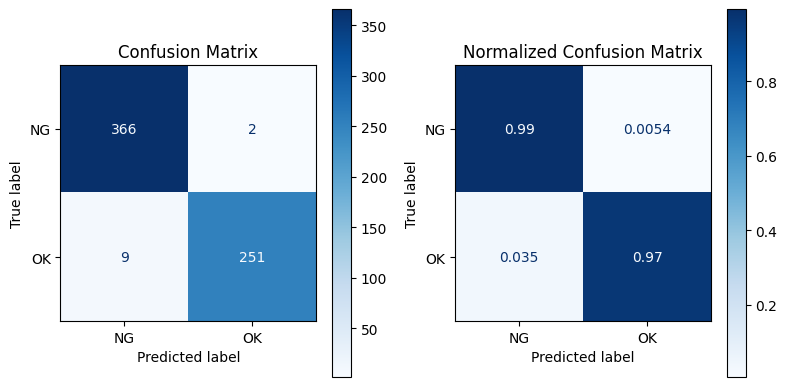

In [134]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

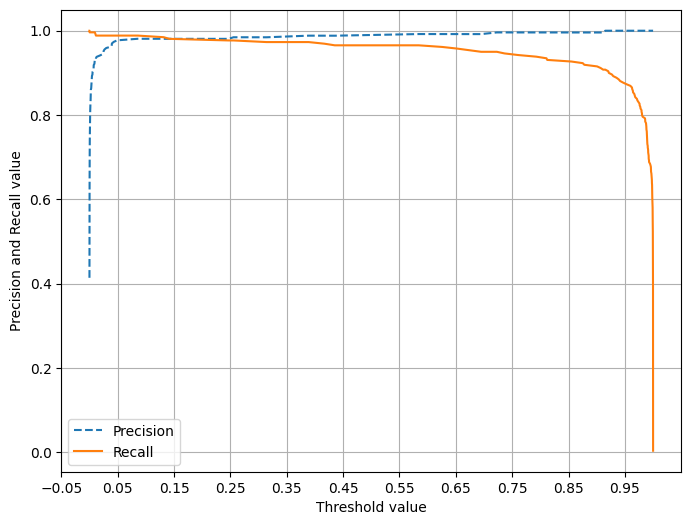

In [135]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [136]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[6.45793961e-08 1.62168888e-07 3.20498998e-07 5.24074323e-07
 7.71227860e-07 9.79191782e-07 1.00973523e-06 1.31835748e-06
 1.35985647e-06 1.37411826e-06 1.40627264e-06 1.49322500e-06
 1.66207246e-06 1.69327541e-06 2.02485376e-06 2.60554702e-06
 2.67011501e-06 2.73997784e-06 2.77672598e-06 3.02035664e-06
 3.21570428e-06 3.67033681e-06 4.43348699e-06 4.45835849e-06
 4.58249042e-06 4.86648287e-06 4.88982732e-06 5.10795280e-06
 5.18601655e-06 5.46022966e-06 5.46558522e-06 5.53070731e-06
 5.68433734e-06 5.80211417e-06 5.99864688e-06 6.19857974e-06
 6.51578421e-06 6.82384552e-06 6.95752396e-06 7.06610399e-06
 7.17038620e-06 7.80172468e-06 8.47105275e-06 8.78606352e-06
 8.80964853e-06 9.25719451e-06 9.57762495e-06 9.90147691e-06
 9.91754314e-06 9.92185687e-06 1.02647755e-05 1.02932918e-05
 1.07920368e-05 1.08068152e-05 1.12235002e-05 1.13363312e-05
 1.16854344e-05 1.18703565e-05 1.21721705e-05 1.22533720e-05
 1.26886644e-05 1.29107693e-05 1.35462942e-05 1.40036436e-05
 1.40352249e-05 1.419671

In [137]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 6.4579396e-08
오차 행렬
[[  1 367]
 [  0 260]]
정확도: 0.4156, 정밀도: 0.4147, 재현율: 1.0000, F1:0.5862, AUC:0.5014
###########################################################################
임곗값: 1.6216889e-07
오차 행렬
[[  2 366]
 [  0 260]]
정확도: 0.4172, 정밀도: 0.4153, 재현율: 1.0000, F1:0.5869, AUC:0.5027
###########################################################################
임곗값: 3.20499e-07
오차 행렬
[[  3 365]
 [  0 260]]
정확도: 0.4188, 정밀도: 0.4160, 재현율: 1.0000, F1:0.5876, AUC:0.5041
###########################################################################
임곗값: 5.240743e-07
오차 행렬
[[  4 364]
 [  0 260]]
정확도: 0.4204, 정밀도: 0.4167, 재현율: 1.0000, F1:0.5882, AUC:0.5054
###########################################################################
임곗값: 7.7122786e-07
오차 행렬
[[  5 363]
 [  0 260]]
정확도: 0.4220, 정밀도: 0.4173, 재현율: 1.0000, F1:0.5889, AUC:0.5068
###########################################################################
임곗값: 9.791918e-07
오차 행렬
[[  6 362]
 [  0 260]]
정확도: 0.4236, 정밀도: 0.4180, 재현율: 

d:\sy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 정확도: 0.9825, 정밀도: 0.9921, 재현율: 0.9654, F1:0.9786, AUC:0.9800

오차 행렬
[[366   2]
 [  9 251]]
정확도: 0.9825, 정밀도: 0.9921, 재현율: 0.9654, F1: 0.9786, ROC-AUC: 0.9800
################################################################################


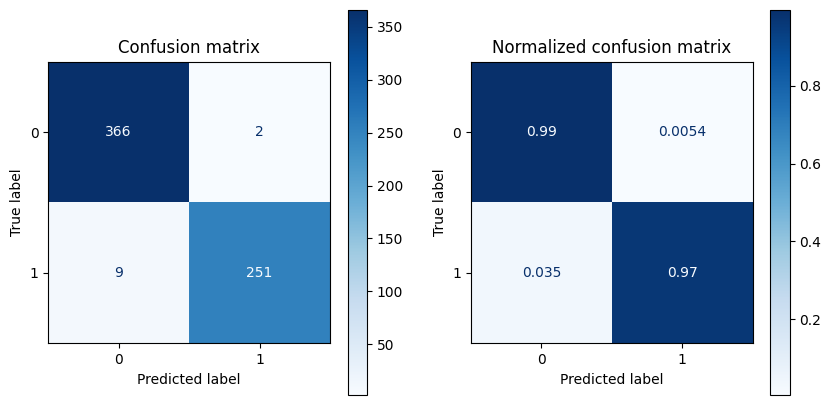

In [138]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.4352675
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)

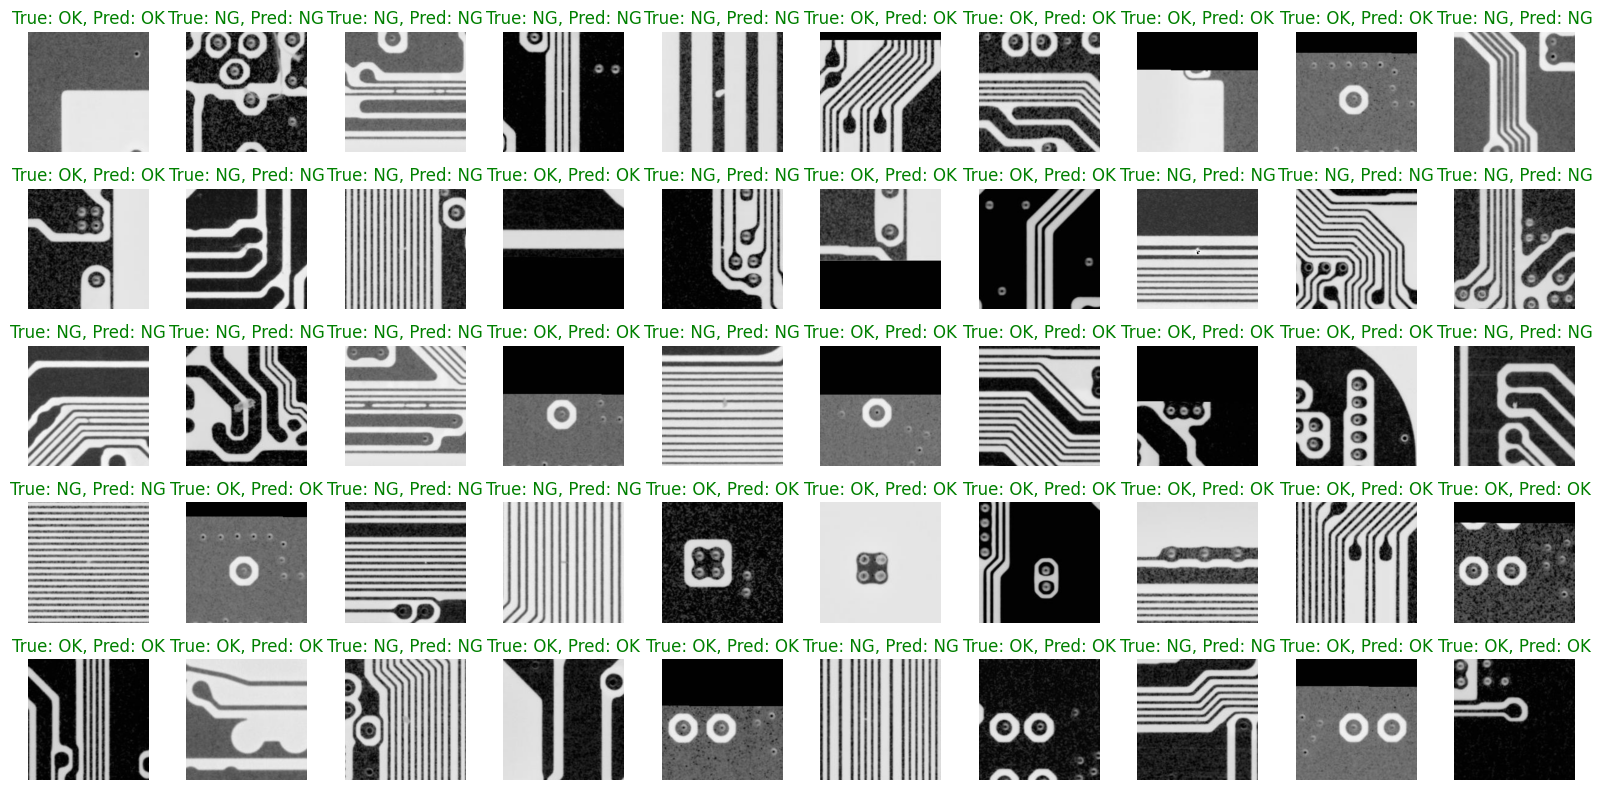

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# 테스트 데이터셋에서 무작위로 10개의 샘플을 선택하는 함수
def get_random_samples(dataset, num_samples=50):
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    return samples, indices

# 이미지 시각화 및 예측 결과 표시
def visualize_predictions(model, dataset, num_samples=50):
    # 모델을 평가 모드로 전환
    model.eval()
    
    # 무작위로 num_samples 개의 샘플 가져오기
    samples, indices = get_random_samples(dataset, num_samples=num_samples)
    
    fig, axs = plt.subplots(5, num_samples//5, figsize=(16, 8))  # 5행
    axs = axs.ravel()
    
    with torch.no_grad():
        for i, (image, label) in enumerate(samples):
            # 이미지와 레이블 준비
            image_input = image.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 및 장치로 이동
            label = label.item()
            
            # 예측 수행
            output = model(image_input)
            pred = torch.sigmoid(output).item()
            pred_label = 1 if pred > 0.5 else 0
            
            # 이미지를 numpy로 변환하여 시각화
            image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            image_np = (image_np * 255).astype(np.uint8)  # [0, 1] 범위에서 [0, 255] 범위로 변환
            
            # 정답/오답에 따른 레이블 색상 결정
            color = 'green' if pred_label == label else 'red'  # 정답일 때 녹색, 오답일 때 빨간색

            label_name = 'NG' if label == 0 else 'OK'
            pred_label_name = 'NG' if pred_label == 0 else 'OK'

            # 이미지 및 레이블 출력
            axs[i].imshow(image_np)
            axs[i].set_title(f"True: {label_name}, Pred: {pred_label_name}", color=color)
            axs[i].axis('off')  # 축 제거
    
    plt.tight_layout()
    plt.show()

# 모델을 사용하여 테스트 데이터에서 무작위 50개 샘플 예측 및 시각화
visualize_predictions(model, test_dataset)